In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pickle
import numpy as np
from scipy.stats import iqr
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import matplotlib.pyplot as plt


In [2]:
# training parameters
epochs = 100
batch_size = 8
# loss = tf.keras.losses.MeanAbsoluteError()
# opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.90)
input_path = '../../data/'
output_path = './model/'


In [3]:
# load data
x_train = pickle.load(open(input_path+'/x_train.pkl', 'rb'))
y_train = pickle.load(open(input_path+'/y_train.pkl', 'rb'))
sizes_train = pickle.load(open(input_path+'/sizes_train.pkl', 'rb'))
x_val = pickle.load(open(input_path+'/x_test.pkl', 'rb'))
y_val = pickle.load(open(input_path+'/y_test.pkl', 'rb'))
sizes_val = pickle.load(open(input_path+'/sizes_test.pkl', 'rb'))


In [4]:
# standardize
x_train = [np.array(i) for i in x_train]
x_val = [np.array(i) for i in x_val]

y_train = [(i-j.mean())/j.std() for i,j in zip(y_train, x_train)]
y_val = [(i-j.mean())/j.std() for i,j in zip(y_val, x_val)]
x_train = [(i-i.mean())/i.std() for i in x_train]
x_val = [(i-i.mean())/i.std() for i in x_val]


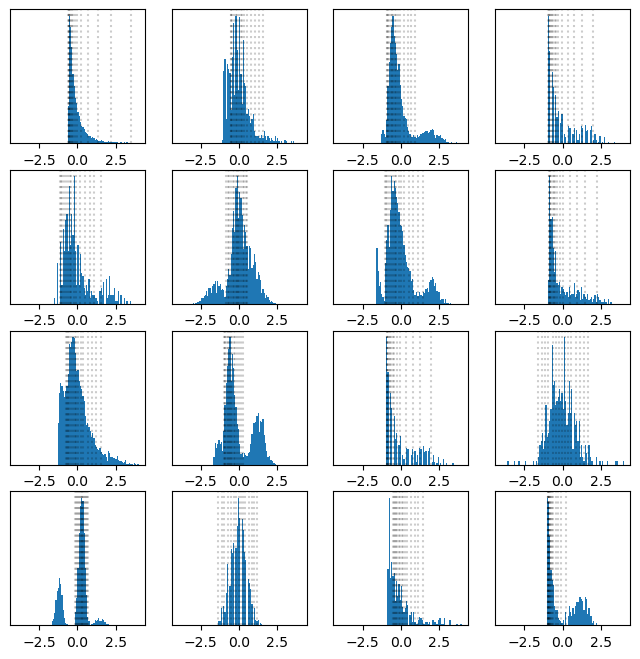

In [5]:
# plot example data points
nr = 4
nc = 4
plt.figure(figsize=(8,8))
idx = np.random.choice(len(x_train), nr*nc)
bins = np.linspace(-4, 4, 101)
for i in range(nr*nc):
    plt.subplot(nr, nc, i+1)
    plt.hist(x_train[idx[i]], bins, density=True)
    for j in range(len(y_train[0])):
        plt.axvline(y_train[idx[i]][j], c='k', linestyle=':', alpha=0.2)
    plt.yticks([])
    

In [6]:
# optionally add size prediction

y_train = np.array(y_train)
y_train = np.hstack([
    y_train, 
    np.array([i[0]/sum(i) for i in sizes_train]).reshape(-1, 1)
])

y_val = np.array(y_val)
y_val = np.hstack([
    y_val, 
    np.array([i[0]/sum(i) for i in sizes_val]).reshape(-1, 1)
])


In [7]:
def extract_features(data):

    features = np.histogram(data, np.linspace(-4, 4, 101), density=True)[0]
    features = (features - features.min())/(features.max() - features.min())
    
    return features.reshape(-1, 1)


In [8]:
# extract features
x_train = [extract_features(i) for i in x_train]
x_train = np.array(x_train)
x_val = [extract_features(i) for i in x_val]
x_val = np.array(x_val)


In [9]:
x_train.shape

(5000, 100, 1)

In [10]:
y_train.shape


(5000, 16)

In [11]:
# standardize

scalery = RobustScaler()
y_train = scalery.fit_transform(y_train)
y_val = scalery.transform(y_val)


In [12]:
# define model

inputs = tf.keras.layers.Input(shape=x_train.shape[1:])
x = tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu')(inputs)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
o = tf.keras.layers.Dense(y_val.shape[1], activation='linear')(x)
model = tf.keras.models.Model(inputs, o)

# define loss and optimizer
model.compile(loss = 'mae',
              optimizer = 'adam')

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 98, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 49, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 23, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 21, 64)            12352 

In [13]:
# define best model checkpoint
checkpoint_path = output_path+'/model_checkpoint'
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    save_format='tf',
    verbose=1
)

# train
history = model.fit(
    x_train, 
    y_train,
    validation_data = (x_val, y_val),
    epochs = epochs,
    batch_size = batch_size,
    callbacks = [checkpoint_callback],
    verbose = 2
)

with open(output_path+'/model_history.npy', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)



Epoch 1/100


I0000 00:00:1716801049.095737   30910 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 0.24453, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 12s - loss: 0.3410 - val_loss: 0.2445 - 12s/epoch - 19ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.24453 to 0.20560, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 5s - loss: 0.2543 - val_loss: 0.2056 - 5s/epoch - 7ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.20560 to 0.19630, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.2273 - val_loss: 0.1963 - 4s/epoch - 6ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.19630 to 0.17727, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.2136 - val_loss: 0.1773 - 4s/epoch - 6ms/step
Epoch 5/100

Epoch 5: val_loss improved from 0.17727 to 0.17482, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.2012 - val_loss: 0.1748 - 4s/epoch - 6ms/step
Epoch 6/100

Epoch 6: val_loss improved from 0.17482 to 0.16920, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.1930 - val_loss: 0.1692 - 4s/epoch - 6ms/step
Epoch 7/100

Epoch 7: val_loss improved from 0.16920 to 0.16544, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.1874 - val_loss: 0.1654 - 4s/epoch - 6ms/step
Epoch 8/100

Epoch 8: val_loss improved from 0.16544 to 0.16537, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.1830 - val_loss: 0.1654 - 4s/epoch - 6ms/step
Epoch 9/100

Epoch 9: val_loss improved from 0.16537 to 0.15912, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.1772 - val_loss: 0.1591 - 4s/epoch - 6ms/step
Epoch 10/100

Epoch 10: val_loss improved from 0.15912 to 0.15828, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.1751 - val_loss: 0.1583 - 4s/epoch - 6ms/step
Epoch 11/100

Epoch 11: val_loss improved from 0.15828 to 0.15449, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.1749 - val_loss: 0.1545 - 4s/epoch - 6ms/step
Epoch 12/100

Epoch 12: val_loss improved from 0.15449 to 0.15005, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.1712 - val_loss: 0.1500 - 4s/epoch - 6ms/step
Epoch 13/100

Epoch 13: val_loss improved from 0.15005 to 0.14916, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.1695 - val_loss: 0.1492 - 4s/epoch - 6ms/step
Epoch 14/100

Epoch 14: val_loss did not improve from 0.14916
625/625 - 3s - loss: 0.1655 - val_loss: 0.1562 - 3s/epoch - 4ms/step
Epoch 15/100

Epoch 15: val_loss did not improve from 0.14916
625/625 - 3s - loss: 0.1626 - val_loss: 0.1502 - 3s/epoch - 5ms/step
Epoch 16/100

Epoch 16: val_loss did not improve from 0.14916
625/625 - 3s - loss: 0.1620 - val_loss: 0.1537 - 3s/epoch - 4ms/step
Epoch 17/100

Epoch 17: val_loss improved from 0.14916 to 0.14772, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.1598 - val_loss: 0.1477 - 4s/epoch - 6ms/step
Epoch 18/100

Epoch 18: val_loss improved from 0.14772 to 0.14668, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.1571 - val_loss: 0.1467 - 4s/epoch - 6ms/step
Epoch 19/100

Epoch 19: val_loss did not improve from 0.14668
625/625 - 3s - loss: 0.1564 - val_loss: 0.1573 - 3s/epoch - 4ms/step
Epoch 20/100

Epoch 20: val_loss improved from 0.14668 to 0.14100, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.1561 - val_loss: 0.1410 - 4s/epoch - 6ms/step
Epoch 21/100

Epoch 21: val_loss did not improve from 0.14100
625/625 - 3s - loss: 0.1523 - val_loss: 0.1436 - 3s/epoch - 4ms/step
Epoch 22/100

Epoch 22: val_loss did not improve from 0.14100
625/625 - 3s - loss: 0.1554 - val_loss: 0.1494 - 3s/epoch - 5ms/step
Epoch 23/100

Epoch 23: val_loss did not improve from 0.14100
625/625 - 3s - loss: 0.1529 - val_loss: 0.1430 - 3s/epoch - 4ms/step
Epoch 24/100

Epoch 24: val_loss did not improve from 0.14100
625/625 - 3s - loss: 0.1498 - val_loss: 0.1492 - 3s/epoch - 4ms/step
Epoch 25/100

Epoch 25: val_loss did not improve from 0.14100
625/625 - 3s - loss: 0.1503 - val_loss: 0.1468 - 3s/epoch - 4ms/step
Epoch 26/100

Epoch 26: val_loss did not improve from 0.14100
625/625 - 3s - loss: 0.1483 - val_loss: 0.1452 - 3s/epoch - 4ms/step
Epoch 27/100

Epoch 27: val_loss did not improve from 0.14100
625/625 - 3s - loss: 0.1480 - val_loss: 0.1431 - 3s/epoch - 4ms/step
Epoch 28/100



INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.1458 - val_loss: 0.1408 - 4s/epoch - 6ms/step
Epoch 29/100

Epoch 29: val_loss did not improve from 0.14081
625/625 - 3s - loss: 0.1451 - val_loss: 0.1525 - 3s/epoch - 5ms/step
Epoch 30/100

Epoch 30: val_loss did not improve from 0.14081
625/625 - 3s - loss: 0.1461 - val_loss: 0.1457 - 3s/epoch - 5ms/step
Epoch 31/100

Epoch 31: val_loss did not improve from 0.14081
625/625 - 3s - loss: 0.1419 - val_loss: 0.1485 - 3s/epoch - 5ms/step
Epoch 32/100

Epoch 32: val_loss did not improve from 0.14081
625/625 - 3s - loss: 0.1435 - val_loss: 0.1435 - 3s/epoch - 5ms/step
Epoch 33/100

Epoch 33: val_loss did not improve from 0.14081
625/625 - 3s - loss: 0.1421 - val_loss: 0.1509 - 3s/epoch - 4ms/step
Epoch 34/100

Epoch 34: val_loss did not improve from 0.14081
625/625 - 3s - loss: 0.1414 - val_loss: 0.1464 - 3s/epoch - 5ms/step
Epoch 35/100

Epoch 35: val_loss did not improve from 0.14081
625/625 - 3s - loss: 0.1406 - val_loss: 0.1469 - 3s/epoch - 4ms/step
Epoch 36/100




Epoch 91: val_loss did not improve from 0.14081
625/625 - 2s - loss: 0.1193 - val_loss: 0.1463 - 2s/epoch - 3ms/step
Epoch 92/100

Epoch 92: val_loss did not improve from 0.14081
625/625 - 2s - loss: 0.1194 - val_loss: 0.1492 - 2s/epoch - 3ms/step
Epoch 93/100

Epoch 93: val_loss did not improve from 0.14081
625/625 - 2s - loss: 0.1190 - val_loss: 0.1494 - 2s/epoch - 3ms/step
Epoch 94/100

Epoch 94: val_loss did not improve from 0.14081
625/625 - 2s - loss: 0.1183 - val_loss: 0.1523 - 2s/epoch - 3ms/step
Epoch 95/100

Epoch 95: val_loss did not improve from 0.14081
625/625 - 2s - loss: 0.1173 - val_loss: 0.1444 - 2s/epoch - 3ms/step
Epoch 96/100

Epoch 96: val_loss did not improve from 0.14081
625/625 - 2s - loss: 0.1174 - val_loss: 0.1461 - 2s/epoch - 3ms/step
Epoch 97/100

Epoch 97: val_loss did not improve from 0.14081
625/625 - 2s - loss: 0.1190 - val_loss: 0.1511 - 2s/epoch - 3ms/step
Epoch 98/100

Epoch 98: val_loss did not improve from 0.14081
625/625 - 2s - loss: 0.1182 - val_

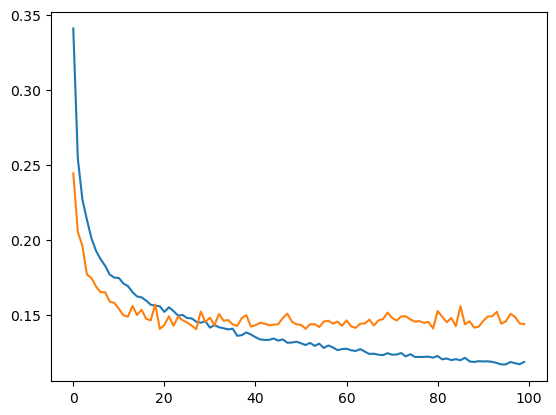

In [14]:
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);


In [15]:
# save scaler
with open(output_path+'/model_y_scaler.pkl', 'wb') as f:
    pickle.dump(scalery, f)
